# **Mount Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import Libraries**

In [2]:
import pandas as pd
import warnings
import os
import torch
import json
import gc
import shutil
import contextlib
import sys
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import seaborn as sns
import time
from io import StringIO
from datetime import datetime
from torch.optim import Adam, AdamW, SGD
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from torch.utils.data import DataLoader, Dataset
from sklearn import svm
from IPython.display import display, clear_output, HTML
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

#  **Import Data for Training and Validation**

In [3]:
os.chdir("/content/drive/MyDrive/Unhas/S1/Alip")
print("Current directory:", os.getcwd())

data = pd.read_csv("newdata_brabtra_fc.csv") # Ganti ini dengan nama file data balance

# data["Kata Negatif Eksplisit Terdeteksi"].fillna("", inplace=True)
# data["Kata Positif Terdeteksi"].fillna("", inplace=True)
data = data[["Isi Bersih", "label"]]
data.head()

Current directory: /content/drive/MyDrive/Unhas/S1/Alip


,Isi Bersih,label
0,kebakaran3 rumah dan kios terjadi di lingkunga...,0
1,penasihat menko kemaritiman dan investasi dr d...,1
2,event balap street race bsd yang digelar pada ...,1
3,banjir turut menerjang kabupaten karawang kaba...,1
4,sebuah video menunjukkan aksi seorang pria did...,0


#  **Split Data**

In [4]:
split_path = "split_data_balance_version2.json"
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

if os.path.exists(split_path):
  print("📂 Memuat data split yang sudah ada...")
  with open(split_path, "r") as f:
    split = json.load(f)
  train_texts = split["train_texts"]
  val_texts = split["val_texts"]
  train_labels = split["train_labels"]
  val_labels = split["val_labels"]
else:
  print("🧪 Melakukan split data pertama kali...")
  train_texts, val_texts, train_labels, val_labels = train_test_split(
      data["Isi Bersih"].tolist(),
      data["label"].tolist(),
      test_size=0.2,
      stratify=data['label'],
      random_state=42
  )
  with open(split_path, "w") as f:
    json.dump({
        "train_texts": train_texts,
        "val_texts": val_texts,
        "train_labels": train_labels,
        "val_labels": val_labels
    }, f)
  print("✅ Split data disimpan ke 'split_data_balance.json'")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

📂 Memuat data split yang sudah ada...


# **Class for News Dataset**

In [5]:
class NewsDataset(Dataset):
  def __init__(self, texts, labels):
    self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
    self.labels = labels

  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item["labels"] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

train_dataset = NewsDataset(train_texts, train_labels)
val_dataset = NewsDataset(val_texts, val_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

# **Class for Model IndoBERT**

In [6]:
class IndoBERTClassifier(nn.Module):
    def __init__(
        self,
        model_name="indobenchmark/indobert-base-p1",
        num_labels=2,
        classifier_type="cnn",  # "ann", "lstm", or "cnn"
        use_dropout=False,
        dropout_rate=0.1,
        hidden_dim=256  # optional for LSTM and CNN
    ):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.classifier_type = classifier_type.lower()

        self.dropout = nn.Dropout(dropout_rate) if use_dropout else nn.Identity()

        if self.classifier_type == "ann":
            self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

        elif self.classifier_type == "lstm":
            self.lstm = nn.LSTM(
                input_size=self.bert.config.hidden_size,
                hidden_size=hidden_dim,
                num_layers=1,
                batch_first=True,
                bidirectional=True
            )
            self.classifier = nn.Linear(hidden_dim * 2, num_labels)

        elif self.classifier_type == "cnn":
            self.conv1 = nn.Conv1d(
                in_channels=self.bert.config.hidden_size,
                out_channels=hidden_dim,
                kernel_size=3,
                padding=1
            )
            self.pool = nn.AdaptiveMaxPool1d(1)
            self.classifier = nn.Linear(hidden_dim, num_labels)

        else:
            raise ValueError(f"Unsupported classifier type: {classifier_type}")

    def forward(self, input_ids, attention_mask, token_type_ids=None, labels=None):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        if self.classifier_type == "ann":
            pooled_output = outputs.last_hidden_state[:, 0]  # [CLS] token
            pooled_output = self.dropout(pooled_output)
            logits = self.classifier(pooled_output)

        elif self.classifier_type == "lstm":
            lstm_output, _ = self.lstm(outputs.last_hidden_state)
            pooled_output = self.dropout(lstm_output[:, -1, :])  # use last time step
            logits = self.classifier(pooled_output)

        elif self.classifier_type == "cnn":
            x = outputs.last_hidden_state.transpose(1, 2)  # shape: [batch, hidden, seq_len]
            x = F.relu(self.conv1(x))                      # shape: [batch, hidden_dim, seq_len]
            x = self.pool(x).squeeze(-1)                   # shape: [batch, hidden_dim]
            x = self.dropout(x)
            logits = self.classifier(x)

        loss = None
        if labels is not None:
            loss = F.cross_entropy(logits, labels)

        return {"loss": loss, "logits": logits}

# **Training Model Dashboard**

In [7]:
class PersistentTrainingDashboard:
    def __init__(self, scenario_name):
        self.scenario_name = scenario_name
        self.logs = []
        self.start_time = time.time()
        self.current_epoch = 0
        self.total_epochs = 0
        self.config = None
        self.training_status = "Initializing"
        self.current_batch = 0
        self.total_batches = 0
        self.current_loss = 0.0
        self.avg_loss = 0.0
        self.best_accuracy = 0.0
        self.epochs_no_improve = 0
        self.messages = []

    def set_config(self, config):
        """Set training configuration"""
        self.config = config
        self.total_epochs = config['num_epochs']

    def add_message(self, message, msg_type="info"):
        """Add message to display"""
        timestamp = datetime.now().strftime('%H:%M:%S')
        self.messages.append({
            'time': timestamp,
            'message': message,
            'type': msg_type
        })
        # Keep only last 10 messages
        if len(self.messages) > 10:
            self.messages = self.messages[-10:]

    def add_log(self, log):
        """Add new log entry"""
        self.logs.append(log)
        self.current_epoch = log['epoch']
        if log['accuracy'] > self.best_accuracy:
            self.best_accuracy = log['accuracy']
            self.epochs_no_improve = 0
            self.add_message("🎉 New best model saved!", "success")
        else:
            self.epochs_no_improve += 1
            if self.epochs_no_improve > 0:
                self.add_message(f"⏳ No improvement for {self.epochs_no_improve} epoch(s)", "warning")

    def format_time(self, seconds):
        """Format seconds to HH:MM:SS"""
        hours = int(seconds // 3600)
        minutes = int((seconds % 3600) // 60)
        secs = int(seconds % 60)
        return f"{hours:02d}:{minutes:02d}:{secs:02d}"

    def create_header_section(self):
        """Create header section with scenario info"""
        start_time_str = datetime.fromtimestamp(self.start_time).strftime('%Y-%m-%d %H:%M:%S')
        elapsed = time.time() - self.start_time

        return f"""
        <div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); padding: 25px; border-radius: 15px; margin: 10px 0; box-shadow: 0 4px 15px rgba(0,0,0,0.2);">
            <h1 style="color: white; text-align: center; margin: 0; font-size: 28px; text-shadow: 2px 2px 4px rgba(0,0,0,0.3);">
                🚀 {self.scenario_name}
            </h1>
            <p style="color: #E0E0E0; text-align: center; margin: 10px 0; font-size: 16px;">
                Started: {start_time_str} | Elapsed: {self.format_time(elapsed)}
            </p>
        </div>
        """

    def create_config_section(self):
        """Create configuration section"""
        if not self.config:
            return ""

        return f"""
        <div style="background: rgba(255,255,255,0.95); padding: 20px; border-radius: 10px; margin: 10px 0; box-shadow: 0 2px 8px rgba(0,0,0,0.1);">
            <h3 style="color: #333; margin: 0 0 15px 0; text-align: center;">📊 Training Configuration</h3>
            <div style="display: grid; grid-template-columns: repeat(auto-fit, minmax(200px, 1fr)); gap: 15px;">
                <div style="background: #f8f9fa; padding: 12px; border-radius: 8px; border-left: 4px solid #667eea;">
                    <strong style="color: #333;">Total Epochs:</strong> <span style="color: #666;">{self.config['num_epochs']}</span>
                </div>
                <div style="background: #f8f9fa; padding: 12px; border-radius: 8px; border-left: 4px solid #667eea;">
                    <strong style="color: #333;">Optimizer:</strong> <span style="color: #666;">{self.config['optimizer']}</span>
                </div>
                <div style="background: #f8f9fa; padding: 12px; border-radius: 8px; border-left: 4px solid #667eea;">
                    <strong style="color: #333;">Learning Rate:</strong> <span style="color: #666;">{self.config['lr']}</span>
                </div>
                <div style="background: #f8f9fa; padding: 12px; border-radius: 8px; border-left: 4px solid #667eea;">
                    <strong style="color: #333;">Patience:</strong> <span style="color: #666;">{self.config['patience']}</span>
                </div>
            </div>
        </div>
        """

    def create_status_section(self):
        """Create current status section"""
        elapsed = time.time() - self.start_time

        # Progress calculation
        epoch_progress = 0
        if self.total_batches > 0:
            epoch_progress = (self.current_batch / self.total_batches) * 100

        overall_progress = 0
        if self.total_epochs > 0:
            overall_progress = ((self.current_epoch - 1 + epoch_progress/100) / self.total_epochs) * 100

        # Progress bars
        epoch_bar_length = 30
        epoch_filled = int(epoch_progress / 100 * epoch_bar_length)
        epoch_bar = "█" * epoch_filled + "░" * (epoch_bar_length - epoch_filled)

        overall_bar_length = 30
        overall_filled = int(overall_progress / 100 * overall_bar_length)
        overall_bar = "█" * overall_filled + "░" * (overall_bar_length - overall_filled)

        return f"""
        <div style="background: rgba(255,255,255,0.95); padding: 20px; border-radius: 10px; margin: 10px 0; box-shadow: 0 2px 8px rgba(0,0,0,0.1);">
            <h3 style="color: #333; margin: 0 0 15px 0; text-align: center;">⚡ Current Status</h3>

            <div style="display: grid; grid-template-columns: repeat(auto-fit, minmax(200px, 1fr)); gap: 15px; margin-bottom: 20px;">
                <div style="background: #e3f2fd; padding: 15px; border-radius: 8px; text-align: center;">
                    <h4 style="color: #1976d2; margin: 0;">Current Epoch</h4>
                    <p style="color: #333; font-size: 24px; margin: 5px 0; font-weight: bold;">{self.current_epoch}/{self.total_epochs}</p>
                </div>
                <div style="background: #f3e5f5; padding: 15px; border-radius: 8px; text-align: center;">
                    <h4 style="color: #7b1fa2; margin: 0;">Status</h4>
                    <p style="color: #333; font-size: 18px; margin: 5px 0; font-weight: bold;">{self.training_status}</p>
                </div>
                <div style="background: #e8f5e8; padding: 15px; border-radius: 8px; text-align: center;">
                    <h4 style="color: #388e3c; margin: 0;">Current Loss</h4>
                    <p style="color: #333; font-size: 18px; margin: 5px 0; font-weight: bold;">{self.current_loss:.4f}</p>
                </div>
                <div style="background: #fff3e0; padding: 15px; border-radius: 8px; text-align: center;">
                    <h4 style="color: #f57c00; margin: 0;">Best Accuracy</h4>
                    <p style="color: #333; font-size: 18px; margin: 5px 0; font-weight: bold;">{self.best_accuracy*100:.2f}%</p>
                </div>
            </div>

            <div style="margin-bottom: 15px;">
                <div style="display: flex; justify-content: space-between; margin-bottom: 5px;">
                    <span style="color: #333; font-weight: bold;">Epoch Progress:</span>
                    <span style="color: #666;">{self.current_batch}/{self.total_batches} ({epoch_progress:.1f}%)</span>
                </div>
                <div style="font-family: monospace; font-size: 14px; color: #333; background: #f5f5f5; padding: 8px; border-radius: 4px;">
                    |{epoch_bar}|
                </div>
            </div>

            <div>
                <div style="display: flex; justify-content: space-between; margin-bottom: 5px;">
                    <span style="color: #333; font-weight: bold;">Overall Progress:</span>
                    <span style="color: #666;">{overall_progress:.1f}%</span>
                </div>
                <div style="font-family: monospace; font-size: 14px; color: #333; background: #f5f5f5; padding: 8px; border-radius: 4px;">
                    |{overall_bar}|
                </div>
            </div>
        </div>
        """

    def create_messages_section(self):
        """Create messages section"""
        if not self.messages:
            return ""

        messages_html = """
        <div style="background: rgba(255,255,255,0.95); padding: 20px; border-radius: 10px; margin: 10px 0; box-shadow: 0 2px 8px rgba(0,0,0,0.1);">
            <h3 style="color: #333; margin: 0 0 15px 0; text-align: center;">📢 Recent Messages</h3>
            <div style="max-height: 200px; overflow-y: auto;">
        """

        for msg in reversed(self.messages[-5:]):  # Show last 5 messages
            color = "#28a745" if msg['type'] == "success" else "#ffc107" if msg['type'] == "warning" else "#17a2b8"
            messages_html += f"""
                <div style="background: #f8f9fa; padding: 10px; margin: 5px 0; border-radius: 5px; border-left: 4px solid {color};">
                    <span style="color: #666; font-size: 12px;">[{msg['time']}]</span>
                    <span style="color: #333; margin-left: 10px;">{msg['message']}</span>
                </div>
            """

        messages_html += "</div></div>"
        return messages_html

    def create_metrics_plots(self):
        """Create interactive plotly plots for all metrics"""
        if not self.logs:
            return None

        epochs = [log['epoch'] for log in self.logs]

        # Create subplots
        fig = make_subplots(
            rows=2, cols=3,
            subplot_titles=['🔥 Training Loss', '📉 Validation Loss', '🎯 Accuracy (%)',
                          '🔍 Precision (%)', '📢 Recall (%)', '📊 Loss Comparison'],
            specs=[[{}, {}, {}],
                   [{}, {}, {}]]
        )

        # Colors for each metric
        colors = {
            'train_loss': '#FF6B6B',
            'val_loss': '#4ECDC4',
            'accuracy': '#45B7D1',
            'precision': '#96CEB4',
            'recall': '#FFEAA7'
        }

        # Training Loss
        fig.add_trace(
            go.Scatter(x=epochs, y=[log['train_loss'] for log in self.logs],
                      mode='lines+markers', name='Train Loss', line=dict(color=colors['train_loss'], width=3),
                      marker=dict(size=6)), row=1, col=1
        )

        # Validation Loss
        fig.add_trace(
            go.Scatter(x=epochs, y=[log['val_loss'] for log in self.logs],
                      mode='lines+markers', name='Val Loss', line=dict(color=colors['val_loss'], width=3),
                      marker=dict(size=6)), row=1, col=2
        )

        # Accuracy
        fig.add_trace(
            go.Scatter(x=epochs, y=[log['accuracy']*100 for log in self.logs],
                      mode='lines+markers', name='Accuracy', line=dict(color=colors['accuracy'], width=3),
                      marker=dict(size=6)), row=1, col=3
        )

        # Precision
        fig.add_trace(
            go.Scatter(x=epochs, y=[log['precision']*100 for log in self.logs],
                      mode='lines+markers', name='Precision', line=dict(color=colors['precision'], width=3),
                      marker=dict(size=6)), row=2, col=1
        )

        # Recall
        fig.add_trace(
            go.Scatter(x=epochs, y=[log['recall']*100 for log in self.logs],
                      mode='lines+markers', name='Recall', line=dict(color=colors['recall'], width=3),
                      marker=dict(size=6)), row=2, col=2
        )

        # Loss Comparison
        fig.add_trace(
            go.Scatter(x=epochs, y=[log['train_loss'] for log in self.logs],
                      mode='lines+markers', name='Train Loss', line=dict(color=colors['train_loss'], width=2),
                      marker=dict(size=4), showlegend=False), row=2, col=3
        )
        fig.add_trace(
            go.Scatter(x=epochs, y=[log['val_loss'] for log in self.logs],
                      mode='lines+markers', name='Val Loss', line=dict(color=colors['val_loss'], width=2),
                      marker=dict(size=4), showlegend=False), row=2, col=3
        )

        # Update layout
        fig.update_layout(
            height=600,
            showlegend=False,
            template='plotly_white',
            margin=dict(t=50, b=50, l=50, r=50)
        )

        # Update axes labels
        for i in range(1, 4):
            fig.update_xaxes(title_text="Epoch", row=2, col=i)
            fig.update_xaxes(title_text="Epoch", row=1, col=i)

        fig.update_yaxes(title_text="Loss", row=1, col=1)
        fig.update_yaxes(title_text="Loss", row=1, col=2)
        fig.update_yaxes(title_text="Accuracy (%)", row=1, col=3)
        fig.update_yaxes(title_text="Precision (%)", row=2, col=1)
        fig.update_yaxes(title_text="Recall (%)", row=2, col=2)
        fig.update_yaxes(title_text="Loss", row=2, col=3)

        return fig

    def create_logs_table(self):
        """Create recent logs table with better colors"""
        if not self.logs:
            return ""

        # Show last 10 epochs
        recent_logs = self.logs[-10:]

        table_html = """
        <div style="background: rgba(255,255,255,0.95); padding: 20px; border-radius: 10px; margin: 10px 0; box-shadow: 0 2px 8px rgba(0,0,0,0.1);">
            <h3 style="color: #333; text-align: center; margin: 0 0 15px 0;">📋 Training History</h3>
            <div style="overflow-x: auto;">
                <table style="width: 100%; border-collapse: collapse; margin: 0; background: white; border-radius: 8px; overflow: hidden; box-shadow: 0 1px 3px rgba(0,0,0,0.1);">
                    <thead>
                        <tr style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); color: white;">
                            <th style="padding: 15px; text-align: center; font-weight: bold;">Epoch</th>
                            <th style="padding: 15px; text-align: center; font-weight: bold;">Train Loss</th>
                            <th style="padding: 15px; text-align: center; font-weight: bold;">Val Loss</th>
                            <th style="padding: 15px; text-align: center; font-weight: bold;">Accuracy</th>
                            <th style="padding: 15px; text-align: center; font-weight: bold;">Precision</th>
                            <th style="padding: 15px; text-align: center; font-weight: bold;">Recall</th>
                            <th style="padding: 15px; text-align: center; font-weight: bold;">Time</th>
                        </tr>
                    </thead>
                    <tbody>
        """

        for i, log in enumerate(recent_logs):
            # Highlight best accuracy row
            is_best = log['accuracy'] == max([l['accuracy'] for l in self.logs])
            row_style = "background: #e8f5e8;" if is_best else f"background: {'#f8f9fa' if i % 2 == 0 else '#ffffff'};"

            table_html += f"""
                <tr style="{row_style}">
                    <td style="padding: 12px; text-align: center; font-weight: bold; color: #333;">
                        {log['epoch']} {'🏆' if is_best else ''}
                    </td>
                    <td style="padding: 12px; text-align: center; color: #333;">{log['train_loss']:.4f}</td>
                    <td style="padding: 12px; text-align: center; color: #333;">{log['val_loss']:.4f}</td>
                    <td style="padding: 12px; text-align: center; color: #333; font-weight: {'bold' if is_best else 'normal'};">
                        {log['accuracy']*100:.2f}%
                    </td>
                    <td style="padding: 12px; text-align: center; color: #333;">{log['precision']*100:.2f}%</td>
                    <td style="padding: 12px; text-align: center; color: #333;">{log['recall']*100:.2f}%</td>
                    <td style="padding: 12px; text-align: center; color: #666; font-size: 12px;">
                        {self.format_time(log.get('epoch_time', 0))}
                    </td>
                </tr>
            """

        table_html += """
                    </tbody>
                </table>
            </div>
        </div>
        """
        return table_html

    def update_training_progress(self, epoch, batch_idx, total_batches, current_loss, avg_loss):
        """Update dashboard during training (within epoch)"""
        self.current_epoch = epoch
        self.current_batch = batch_idx
        self.total_batches = total_batches
        self.current_loss = current_loss
        self.avg_loss = avg_loss
        self.training_status = f"Training Epoch {epoch}"
        self.update_dashboard()

    def update_validation_progress(self, epoch):
        """Update dashboard during validation"""
        self.training_status = f"Validating Epoch {epoch}"
        self.add_message(f"📊 Evaluating epoch {epoch}...", "info")
        self.update_dashboard()

    def set_early_stopping(self):
        """Set early stopping status"""
        self.training_status = "Early Stopping"
        self.add_message(f"⛔ Early stopping triggered after {self.epochs_no_improve} epochs without improvement.", "warning")

    def set_completed(self):
        """Set training completed status"""
        self.training_status = "Completed"
        elapsed = time.time() - self.start_time
        self.add_message(f"✅ Training completed! Total time: {self.format_time(elapsed)}", "success")

    def update_dashboard(self):
        """Update the complete persistent dashboard"""
        clear_output(wait=True)

        # Build complete dashboard HTML
        dashboard_html = self.create_header_section()
        dashboard_html += self.create_config_section()
        dashboard_html += self.create_status_section()
        dashboard_html += self.create_messages_section()

        # Display HTML sections
        display(HTML(dashboard_html))

        # Display plots if available
        if self.logs:
            fig = self.create_metrics_plots()
            if fig:
                fig.show()

        # Display logs table if available
        if self.logs:
            display(HTML(self.create_logs_table()))

# **Function for Training and Validation Model**

In [8]:
def suppress_transformers_warnings():
    """Suppress transformers library warnings and loading messages"""
    warnings.filterwarnings("ignore")

    # Suppress transformers logging
    import transformers
    transformers.logging.set_verbosity_error()

    # Suppress tokenizers warnings
    os.environ["TOKENIZERS_PARALLELISM"] = "false"

    # Suppress huggingface hub logging
    import logging
    logging.getLogger("transformers").setLevel(logging.ERROR)
    logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)
    logging.getLogger("transformers.configuration_utils").setLevel(logging.ERROR)

@contextlib.contextmanager
def suppress_model_loading():
    """Context manager khusus untuk suppress model loading progress bars"""
    import transformers
    from transformers import logging as hf_logging

    # Set verbosity ke ERROR
    old_verbosity = hf_logging.get_verbosity()
    hf_logging.set_verbosity_error()

    # Suppress tqdm untuk model downloads
    import tqdm
    old_tqdm = tqdm.tqdm

    class DummyTqdm:
        def __init__(self, *args, **kwargs):
            pass
        def __enter__(self):
            return self
        def __exit__(self, *args):
            pass
        def update(self, *args):
            pass
        def close(self):
            pass
        def set_description(self, *args):
            pass
        def set_postfix(self, *args):
            pass

    try:
        # Replace tqdm temporarily
        tqdm.tqdm = DummyTqdm
        tqdm.tqdm.tqdm = DummyTqdm

        # Suppress stdout/stderr
        with open(os.devnull, "w") as devnull:
            old_stdout = sys.stdout
            old_stderr = sys.stderr
            try:
                sys.stdout = devnull
                sys.stderr = devnull
                yield
            finally:
                sys.stdout = old_stdout
                sys.stderr = old_stderr

    finally:
        # Restore original tqdm and verbosity
        tqdm.tqdm = old_tqdm
        hf_logging.set_verbosity(old_verbosity)

def clear_gpu():
    torch.cuda.empty_cache()
    gc.collect()

def save_metrics_plot(logs, output_dir, scenario_name):
    # Set style untuk plot yang lebih estetis
    plt.style.use('seaborn-v0_8')
    sns.set_palette("husl")

    epochs = [log['epoch'] for log in logs]

    # Create figure dengan subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'📊 Training Metrics - {scenario_name}', fontsize=20, fontweight='bold', y=0.98)

    # Define metrics dan colors
    metrics_info = {
        'train_loss': {'title': '🔥 Training Loss', 'color': '#FF6B6B', 'ylabel': 'Loss'},
        'val_loss': {'title': '📉 Validation Loss', 'color': '#4ECDC4', 'ylabel': 'Loss'},
        'accuracy': {'title': '🎯 Accuracy', 'color': '#45B7D1', 'ylabel': 'Accuracy (%)'},
        'precision': {'title': '🔍 Precision', 'color': '#96CEB4', 'ylabel': 'Precision (%)'},
        'recall': {'title': '📢 Recall', 'color': '#FFEAA7', 'ylabel': 'Recall (%)'}
    }

    # Plot each metric
    for idx, (metric, info) in enumerate(metrics_info.items()):
        row = idx // 3
        col = idx % 3
        ax = axes[row, col]

        # Get values
        if metric in ['accuracy', 'precision', 'recall']:
            values = [log[metric] * 100 for log in logs]  # Convert to percentage
        else:
            values = [log[metric] for log in logs]

        # Plot dengan style yang bagus
        ax.plot(epochs, values,
                color=info['color'],
                linewidth=3,
                marker='o',
                markersize=6,
                markerfacecolor='white',
                markeredgecolor=info['color'],
                markeredgewidth=2,
                alpha=0.8)

        # Styling
        ax.set_title(info['title'], fontsize=14, fontweight='bold', pad=15)
        ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
        ax.set_ylabel(info['ylabel'], fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.set_facecolor('#FAFAFA')

        # Add value annotations pada point tertinggi/terendah
        if metric in ['accuracy', 'precision', 'recall']:
            best_idx = values.index(max(values))
            ax.annotate(f'Best: {values[best_idx]:.2f}%',
                        xy=(epochs[best_idx], values[best_idx]),
                        xytext=(10, 10), textcoords='offset points',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor=info['color'], alpha=0.7),
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'),
                        fontsize=10, fontweight='bold', color='white')
        else:
            best_idx = values.index(min(values))
            ax.annotate(f'Best: {values[best_idx]:.4f}',
                        xy=(epochs[best_idx], values[best_idx]),
                        xytext=(10, 10), textcoords='offset points',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor=info['color'], alpha=0.7),
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'),
                        fontsize=10, fontweight='bold', color='white')

    # Hide unused subplot
    axes[1, 2].axis('off')

    # Add training summary text di subplot kosong
    summary_text = f"""
📈 Training Summary

Total Epochs: {len(logs)}
Best Accuracy: {max([log['accuracy'] * 100 for log in logs]):.2f}%
Final Train Loss: {logs[-1]['train_loss']:.4f}
Final Val Loss: {logs[-1]['val_loss']:.4f}

Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

    axes[1, 2].text(0.1, 0.5, summary_text,
                    fontsize=12,
                    verticalalignment='center',
                    bbox=dict(boxstyle='round,pad=0.8', facecolor='lightblue', alpha=0.3))

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)

    # Save plot
    plt.savefig(os.path.join(output_dir, "training_metrics.png"),
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.close()

     # Save individual plots juga (untuk backward compatibility)
    for metric in ['train_loss', 'val_loss', 'accuracy', 'precision', 'recall']:
        plt.figure(figsize=(10, 6))

        if metric in ['accuracy', 'precision', 'recall']:
            values = [log[metric] * 100 for log in logs]
            plt.ylabel(f"{metric.capitalize()} (%)")
        else:
            values = [log[metric] for log in logs]
            plt.ylabel(metric.replace('_', ' ').title())

        plt.plot(epochs, values,
                color=metrics_info[metric]['color'],
                linewidth=3,
                marker='o',
                markersize=8,
                markerfacecolor='white',
                markeredgecolor=metrics_info[metric]['color'],
                markeredgewidth=2)

        plt.xlabel("Epoch")
        plt.title(f"{metric.replace('_', ' ').title()} - {scenario_name}")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"{metric}.png"), dpi=300, bbox_inches='tight')
        plt.close()

def evaluate(model, val_loader, device):
    """Evaluate model dengan output yang bersih"""
    model.eval()
    total_loss = 0
    total_preds = []
    total_labels = []
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}

            # Forward pass
            outputs = model(**batch)
            loss = outputs['loss']
            logits = outputs['logits']

            # Accumulate loss
            total_loss += loss.item()

            # Get predictions
            preds = torch.argmax(logits, dim=1)
            labels = batch['labels']

            # Accumulate predictions and labels
            total_preds.extend(preds.cpu().numpy())
            total_labels.extend(labels.cpu().numpy())

            # Calculate running accuracy
            correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    # Calculate final metrics
    avg_loss = total_loss / len(val_loader)
    accuracy = accuracy_score(total_labels, total_preds)
    precision = precision_score(total_labels, total_preds, average="macro", zero_division=0)
    recall = recall_score(total_labels, total_preds, average="macro", zero_division=0)

    return avg_loss, accuracy, precision, recall

def train_model(train_loader, val_loader, config, device):
    """Enhanced training function dengan persistent dashboard"""
    start_time = time.time()

    output_dir = config['output_dir']
    os.makedirs(output_dir, exist_ok=True)

    # Initialize persistent dashboard
    dashboard = PersistentTrainingDashboard(config['name'])
    dashboard.set_config(config)
    dashboard.add_message("🔄 Initializing IndoBERT model...", "info")
    dashboard.update_dashboard()

    # Initialize model quietly
    suppress_transformers_warnings()

    with suppress_model_loading():
        model = IndoBERTClassifier(
            num_labels=2,
            use_dropout=config.get('use_dropout', True),
            dropout_rate=config.get('dropout_rate', 0.1),
            classifier_type=config.get('classifier_type', 'default')
        ).to(device)

    dashboard.add_message("✅ Model initialized successfully!", "success")

    # Initialize optimizer
    if config['optimizer'] == "Adam":
        optimizer = Adam(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == "AdamW":
        optimizer = AdamW(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == "SGD":
        optimizer = SGD(model.parameters(), lr=config['lr'], momentum=0.9)
    else:
        raise ValueError("Unsupported optimizer.")

    resume_path = os.path.join(output_dir, "resume.json")
    logs_path = os.path.join(output_dir, "logs.json")

    start_epoch = 0
    logs = []
    best_val_acc = -1
    epochs_no_improve = 0

    # Load resume data if exists
    if os.path.exists(resume_path):
        dashboard.add_message("📂 Loading checkpoint...", "info")
        with open(resume_path) as f:
            resume_data = json.load(f)
            start_epoch = resume_data['last_epoch'] + 1
            model.load_state_dict(torch.load(os.path.join(output_dir, "last_model.pth"))['model_state_dict'])
            logs = resume_data['logs']
            best_val_acc = resume_data['best_val_acc']
            epochs_no_improve = resume_data['epochs_no_improve']
            config['patience'] = resume_data.get('patience', config['patience'])

        dashboard.logs = logs
        dashboard.best_accuracy = best_val_acc
        dashboard.epochs_no_improve = epochs_no_improve
        dashboard.add_message(f"✅ Resumed from epoch {start_epoch}", "success")

    dashboard.add_message("🚀 Starting training...", "info")
    dashboard.update_dashboard()

    # Suppress future warnings during training
    warnings.filterwarnings("ignore", message=".*encoder_attention_mask.*", category=FutureWarning)

    for epoch in range(start_epoch, config['num_epochs']):
        epoch_start_time = time.time()
        model.train()
        train_loss = 0
        total_batches = len(train_loader)

        # Training loop with enhanced real-time progress
        for batch_idx, batch in enumerate(train_loader):
            batch = {k: v.to(device) for k, v in batch.items()}

            try:
                outputs = model(**batch)
                loss = outputs['loss']

                # Backward pass
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                # Update metrics
                train_loss += loss.item()
                avg_loss = train_loss / (batch_idx + 1)

                # Update dashboard dengan frequency yang optimal
                # Update setiap 5% progress atau minimum setiap 25 batch untuk responsiveness
                update_frequency = max(1, min(total_batches // 20, 25))
                if (batch_idx + 1) % update_frequency == 0 or batch_idx == total_batches - 1:
                    dashboard.update_training_progress(
                        epoch + 1,
                        batch_idx + 1,
                        total_batches,
                        loss.item(),
                        avg_loss
                    )

            except Exception as e:
                dashboard.add_message(f"❌ Exception at batch {batch_idx}: {e}", "error")
                raise e

        # Validation phase
        dashboard.update_validation_progress(epoch + 1)
        avg_train_loss = train_loss / len(train_loader)
        val_loss, val_acc, val_prec, val_rec = evaluate(model, val_loader, device)

        # Calculate epoch time
        epoch_time = time.time() - epoch_start_time

        log = {
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'val_loss': val_loss,
            'accuracy': val_acc,
            'precision': val_prec,
            'recall': val_rec,
            'epoch_time': epoch_time
        }

        # Add log to dashboard (this will update the display)
        dashboard.add_log(log)
        logs.append(log)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({'model_state_dict': model.state_dict()}, os.path.join(output_dir, "best_model.pth"))
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Save checkpoint
        torch.save({'model_state_dict': model.state_dict()}, os.path.join(output_dir, "last_model.pth"))
        with open(logs_path, "w") as f:
            json.dump(logs, f, indent=2)

        with open(resume_path, "w") as f:
            json.dump({
                'last_epoch': epoch,
                'logs': logs,
                'best_val_acc': best_val_acc,
                'epochs_no_improve': epochs_no_improve,
                'patience': config['patience']
            }, f, indent=2)

        # Update dashboard after epoch completion
        dashboard.update_dashboard()

        # Early stopping check
        if epochs_no_improve >= config['patience']:
            dashboard.set_early_stopping()
            dashboard.update_dashboard()
            break

    # Final results and cleanup
    end_time = time.time()
    total_time = end_time - start_time

    # Set completion status
    dashboard.set_completed()
    dashboard.update_dashboard()

    # Save final plots
    if logs:
        save_metrics_plot(logs, output_dir, config['name'])

    clear_gpu()
    return best_val_acc, output_dir

# **Training Model**

In [9]:
def run_all_experiments(train_loader, val_loader, base_dir="/content/experiments"):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  os.makedirs(base_dir, exist_ok=True)

  global_best = {
      "accuracy": -1,
      "output_dir": "",
      "config": {}
  }

  def get_resume_acc(output_dir):
    resume_path = os.path.join(output_dir, "resume.json")
    if os.path.exists(resume_path):
        with open(resume_path) as f:
            resume_data = json.load(f)
            # Check if training reached early stopping criteria based on saved state
            if resume_data.get("epochs_no_improve", 0) >= resume_data.get("patience", 10):
                 # Load the best model's accuracy saved in the resume file
                return resume_data.get("best_val_acc", -1)
    return None  # Not trained or not finished

  # Skenario Pelatihan 1: Tuning Learning Rate
  learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
  best_lr, best_acc = None, -1
  for lr in learning_rates:
    config = {
        "name": f"LR_{lr}",
        "lr": lr,
        "optimizer": "SGD",
        "use_dropout": False,
        "dropout_rate": 0.0,
        "classifier_type": "ann",
        "num_epochs": 100,
        "patience": 10,
        "output_dir": os.path.join(base_dir, f"1_LR_{lr}")
    }
    resumed_acc = get_resume_acc(config["output_dir"])
    if resumed_acc is not None:
      print(f"⏭️ Skipping already trained: {config['name']} (acc={resumed_acc:.4f})")
      acc = resumed_acc
      model_dir = config["output_dir"]
    else:
      acc, model_dir = train_model(train_loader, val_loader, config, device)

    # Update best_lr and best_acc for this skenario
    if acc > best_acc:
      best_acc = acc
      best_lr = lr

    # Update global_best across all skenario
    if acc > global_best["accuracy"]:
      global_best = {
          "accuracy": acc,
          "output_dir": model_dir,
          "config": config
      }

  # Skenario Pelatihan 2: Tuning Optimizer
  optimizers = ["SGD", "Adam", "AdamW"]
  best_optimizer, best_acc = None, -1
  for opt in optimizers:
      config = {
          "name": f"OPT_{opt}",
          "lr": best_lr,
          "optimizer": opt,
          "use_dropout": False,
          "dropout_rate": 0.0,
          "classifier_type": "ann",
          "num_epochs": 100,
          "patience": 10,
          "output_dir": os.path.join(base_dir, f"2_OPT_{opt}")
      }
      resumed_acc = get_resume_acc(config["output_dir"])
      if resumed_acc is not None:
        print(f"⏭️ Skipping already trained: {config['name']} (acc={resumed_acc:.4f})")
        acc = resumed_acc
        model_dir = config["output_dir"]
      else:
        acc, model_dir = train_model(train_loader, val_loader, config, device)

      if acc > best_acc:
          best_acc = acc
          best_optimizer = opt

      if acc > global_best["accuracy"]:
        global_best = {
            "accuracy": acc,
            "output_dir": model_dir,
            "config": config
        }

  # Skenario Pelatihan 3: Tuning Dropout dan Dropout Rate
  dropouts = [(False, 0.0), (True, 0.3), (True, 0.5), (True, 0.7), (True, 0.9)]
  best_dropout, best_acc = (False, 0.0), -1
  for do, dr in dropouts:
      config = {
          "name": f"DO_{do}_DR_{dr}",
          "lr": best_lr,
          "optimizer": best_optimizer,
          "use_dropout": do,
          "dropout_rate": dr,
          "classifier_type": "ann",
          "num_epochs": 100,
          "patience": 10,
          "output_dir": os.path.join(base_dir, f"3_DO_{do}_DR_{dr}")
      }
      resumed_acc = get_resume_acc(config["output_dir"])
      if resumed_acc is not None:
        print(f"⏭️ Skipping already trained: {config['name']} (acc={resumed_acc:.4f})")
        acc = resumed_acc
        model_dir = config["output_dir"]
      else:
        acc, model_dir = train_model(train_loader, val_loader, config, device)
      if acc > best_acc:
          best_acc = acc
          best_dropout = (do, dr)

      if acc > global_best["accuracy"]:
        global_best = {
            "accuracy": acc,
            "output_dir": model_dir,
            "config": config
        }

  # Skenario Pelatihan 4: Tuning Classifier
  classifiers = ["ann", "lstm", "cnn"]
  for clf in classifiers:
      config = {
          "name": f"CLF_{clf}",
          "lr": best_lr,
          "optimizer": best_optimizer,
          "use_dropout": False,
          "dropout_rate": 0.0,
          "classifier_type": clf,
          "num_epochs": 100,
          "patience": 10,
          "output_dir": os.path.join(base_dir, f"4_CLF_{clf}")
      }
      resumed_acc = get_resume_acc(config["output_dir"])
      if resumed_acc is not None:
        print(f"⏭️ Skipping already trained: {config['name']} (acc={resumed_acc:.4f})")
        acc = resumed_acc
        model_dir = config["output_dir"]
      else:
        acc, model_dir = train_model(train_loader, val_loader, config, device)

      if acc > global_best["accuracy"]:
        global_best = {
            "accuracy": acc,
            "output_dir": model_dir,
            "config": config
        }

  # Simpan global_best.json
  with open(os.path.join(base_dir, "global_best.json"), "w") as f:
      json.dump(global_best, f, indent=2)

  print(f"✅ Final best model saved at: {global_best['output_dir']} with accuracy: {global_best['accuracy']:.4f}")


run_all_experiments(train_loader, val_loader, base_dir="Model 2.1")

⏭️ Skipping already trained: LR_0.01 (acc=0.5000)
⏭️ Skipping already trained: LR_0.001 (acc=0.8407)
⏭️ Skipping already trained: LR_0.0001 (acc=0.8464)
⏭️ Skipping already trained: LR_1e-05 (acc=0.8286)
⏭️ Skipping already trained: OPT_SGD (acc=0.8436)
⏭️ Skipping already trained: OPT_Adam (acc=0.8150)
⏭️ Skipping already trained: OPT_AdamW (acc=0.6514)
⏭️ Skipping already trained: DO_False_DR_0.0 (acc=0.8379)
⏭️ Skipping already trained: DO_True_DR_0.3 (acc=0.8393)
⏭️ Skipping already trained: DO_True_DR_0.5 (acc=0.8350)
⏭️ Skipping already trained: DO_True_DR_0.7 (acc=0.8393)
⏭️ Skipping already trained: DO_True_DR_0.9 (acc=0.8379)
⏭️ Skipping already trained: CLF_ann (acc=0.8379)
⏭️ Skipping already trained: CLF_lstm (acc=0.8136)
⏭️ Skipping already trained: CLF_cnn (acc=0.8400)
✅ Final best model saved at: Model 2.1/1_LR_0.0001 with accuracy: 0.8464


# **Training Model Checking-Bias**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifiers = ["cnn", "lstm", "ann"]
base_dir="Model 2.1"
for clf in classifiers:
  config = {
      "name": f"CLF_{clf}",
      "lr": 0.0001,
      "optimizer": "SGD",
      "use_dropout": True,
      "dropout_rate": 0.3,
      "classifier_type": clf,
      "num_epochs": 100,
      "patience": 10,
      "output_dir": os.path.join(base_dir, f"{clf} Re-training")
  }
  acc, model_dir = train_model(train_loader, val_loader, config, device)

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

KeyboardInterrupt: 

# **Testing Model**

In [10]:
import os
os.getcwd()

'/content/drive/MyDrive/Unhas/S1/Alip'

In [11]:
# Untuk Testing

data_test = pd.read_csv("test_2.csv")
data_test = data_test[["isi_berita", "label"]]
print(data_test.shape)
data_test.head()

(42, 2)


,isi_berita,label
0,jakarta dalam rangka riah hari merdeka indones...,1
1,jakarta kecexlakaan maut jadi di jalan pangera...,0
2,serang p polres serang menangmkap 12 laku kera...,0
3,jakarta presiden prabowo subianto undang masya...,1
4,gresik syahrama 36 laku pembunuhhan driver oje...,0


In [12]:
def test_model(model_dir, df_test, clf, device='cuda'):
    """Load trained IndoBERT model, evaluate, and plot confusion matrix"""
    # Load tokenizer IndoBERT
    tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

    # Dataset & DataLoader
    test_dataset = NewsDataset(
        df_test['isi_berita'].tolist(),
        df_test['label'].tolist(),
    )
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    # Load model IndoBERTClassifier
    model = IndoBERTClassifier(
        num_labels=2,
        use_dropout=False,
        dropout_rate=0.0,
        classifier_type=clf
    )
    model_path = os.path.join(model_dir, "best_model.pth")
    if not os.path.exists(model_path):
        model_path = os.path.join(model_dir, "last_model.pth")

    state_dict = torch.load(model_path, map_location=device)['model_state_dict']
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    # Prediction loop
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs['logits']
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    # Metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average="macro", zero_division=0)
    rec = recall_score(all_labels, all_preds, average="macro", zero_division=0)

    print("📊 Test Results")
    print(f"Accuracy : {acc * 100:.2f}%")
    print(f"Precision: {prec * 100:.2f}%")
    print(f"Recall   : {rec * 100:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    labels_unique = sorted(df_test['label'].unique())
    label_names = ["Tidak Layak Anak" if lbl == 0 else "Layak Anak" for lbl in labels_unique]
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False,
                xticklabels=label_names,
                yticklabels=label_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    return acc, prec, rec

Hasil Testing Data
===Testing Model IndoBERT + ANN===


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

📊 Test Results
Accuracy : 83.33%
Precision: 83.41%
Recall   : 83.33%


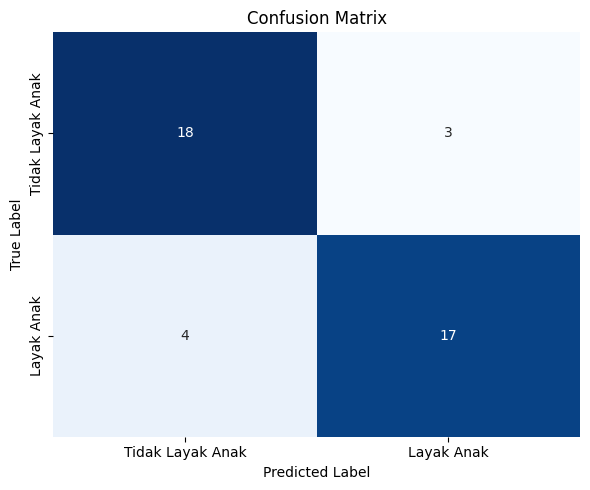

===Testing Model IndoBERT + LSTM===
📊 Test Results
Accuracy : 90.48%
Precision: 90.85%
Recall   : 90.48%


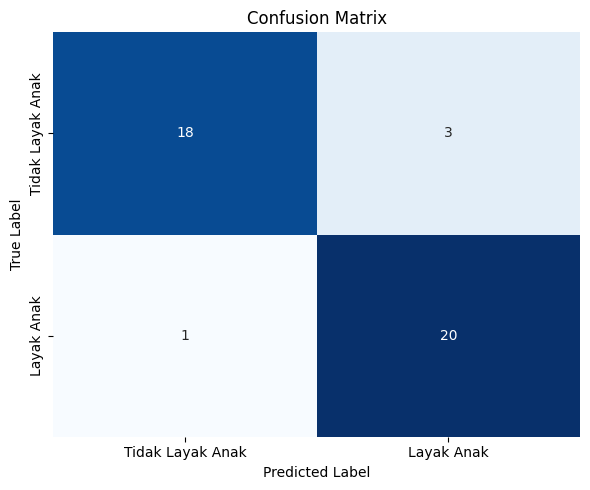

===Testing Model IndoBERT + CNN===
📊 Test Results
Accuracy : 88.10%
Precision: 88.18%
Recall   : 88.10%


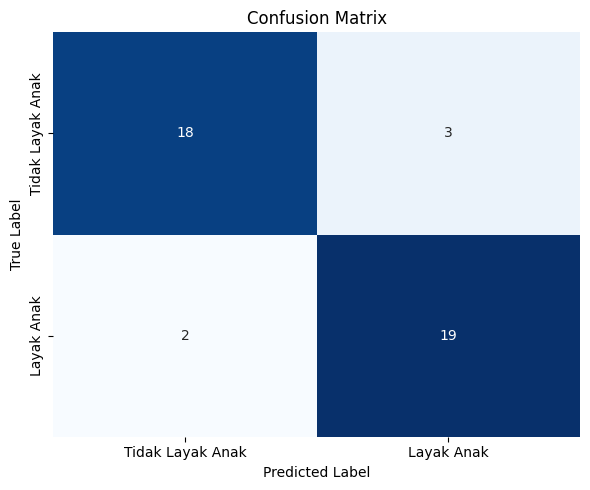

(0.8809523809523809, 0.8818181818181818, 0.8809523809523809)

In [13]:
print("Hasil Testing Data")
print("===Testing Model IndoBERT + ANN===")
test_model(model_dir="Model 2.0/4_CLF_ann", df_test=data_test, device="cuda", clf="ann")
print("===Testing Model IndoBERT + LSTM===")
test_model(model_dir="Model 2.0/4_CLF_lstm", df_test=data_test, device="cuda", clf="lstm")
print("===Testing Model IndoBERT + CNN===")
test_model(model_dir="Model 2.0/4_CLF_cnn", df_test=data_test, device="cuda", clf="cnn")

TESTING

In [ ]:
def test_model(model_dir, df_test, clf, device='cuda'):
    """Load trained IndoBERT model, evaluate, plot confusion matrix, and return predictions"""
    tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

    # Dataset & DataLoader
    test_dataset = NewsDataset(
        df_test['isi_berita'].tolist(),
        df_test['label'].tolist(),
    )
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    # Load model IndoBERTClassifier
    model = IndoBERTClassifier(
        num_labels=2,
        use_dropout=False,
        dropout_rate=0.0,
        classifier_type=clf
    )
    model_path = os.path.join(model_dir, "best_model.pth")
    if not os.path.exists(model_path):
        model_path = os.path.join(model_dir, "last_model.pth")

    state_dict = torch.load(model_path, map_location=device)['model_state_dict']
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    # Prediction loop
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs['logits']
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    # Metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average="macro", zero_division=0)
    rec = recall_score(all_labels, all_preds, average="macro", zero_division=0)

    print("📊 Test Results")
    print(f"Accuracy : {acc * 100:.2f}%")
    print(f"Precision: {prec * 100:.2f}%")
    print(f"Recall   : {rec * 100:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    labels_unique = sorted(df_test['label'].unique())
    label_names = ["Tidak Layak Anak" if lbl == 0 else "Layak Anak" for lbl in labels_unique]
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False,
                xticklabels=label_names,
                yticklabels=label_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Buat DataFrame hasil prediksi
    results_df = df_test.copy()
    results_df["prediksi"] = all_preds
    results_df["prediksi_label"] = results_df["prediksi"].apply(lambda x: "Layak Anak" if x == 1 else "Tidak Layak Anak")
    results_df["label_asli"] = results_df["label"].apply(lambda x: "Layak Anak" if x == 1 else "Tidak Layak Anak")

    return acc, prec, rec, results_df


In [ ]:
acc, prec, rec, hasil_ann = test_model(
    model_dir="Model_2.1/4_CLF_ann",
    df_test=data_test,
    device="cuda",
    clf="ann"
)

# Tampilkan 10 baris pertama
print(hasil_ann.head(10))

# Simpan ke CSV kalau mau analisis lebih lanjut
hasil_ann.to_csv("hasil_prediksi_ann.csv", index=False)


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

OSError: Can't load the model for 'indobenchmark/indobert-base-p1'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure 'indobenchmark/indobert-base-p1' is the correct path to a directory containing a file named pytorch_model.bin, tf_model.h5, model.ckpt or flax_model.msgpack.

Hasil Testing Data Imbalance
===Testing Model IndoBERT + ANN===
📊 Test Results
Accuracy : 88.10%
Precision: 88.10%
Recall   : 88.18%


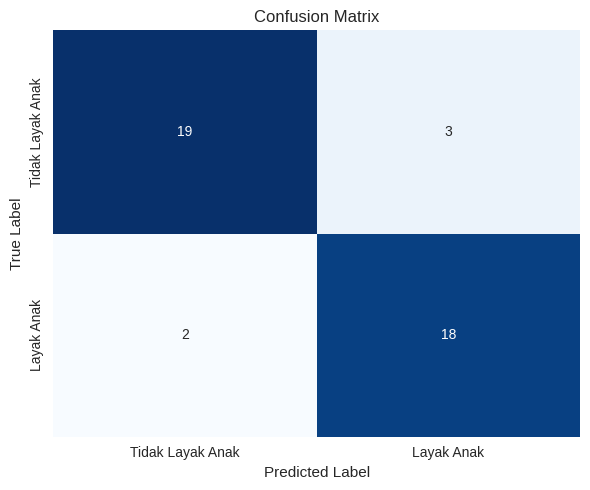

===Testing Model IndoBERT + LSTM===
📊 Test Results
Accuracy : 85.71%
Precision: 85.68%
Recall   : 85.68%


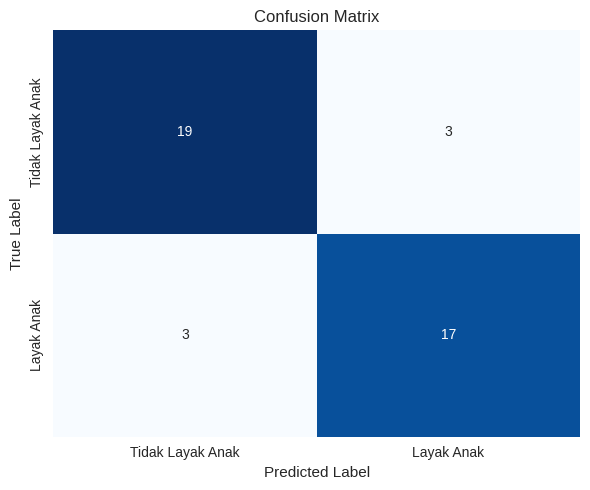

===Testing Model IndoBERT + CNN===
📊 Test Results
Accuracy : 83.33%
Precision: 83.33%
Recall   : 83.41%


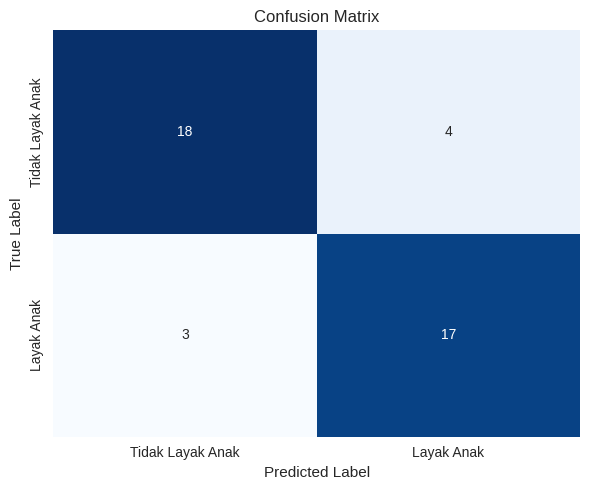

(0.8333333333333334, 0.8333333333333333, 0.8340909090909091)

In [ ]:
print("Hasil Testing Data Imbalance")
print("===Testing Model IndoBERT + ANN===")
test_model(model_dir="Experiments/IMBALANCED/ann", df_test=data_test, device="cuda", clf="ann")
print("===Testing Model IndoBERT + LSTM===")
test_model(model_dir="Experiments/IMBALANCED/lstm", df_test=data_test, device="cuda", clf="lstm")
print("===Testing Model IndoBERT + CNN===")
test_model(model_dir="Experiments/IMBALANCED/cnn", df_test=data_test, device="cuda", clf="cnn")

TESTING PERTABEL

In [ ]:
import os
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from transformers import AutoTokenizer

# ==================== Load Dataset ====================
data_test = pd.read_csv("test123.csv")
data_test = data_test[["isi_berita", "label"]]
print("Data Testing Shape:", data_test.shape)
print(data_test.head())

# ==================== Testing Function ====================
def test_model(model_dir, df_test, clf, device='cuda'):
    """Load trained IndoBERT model, evaluate, and return per-data predictions"""
    tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

    # Dataset & DataLoader
    test_dataset = NewsDataset(
        df_test['isi_berita'].tolist(),
        df_test['label'].tolist(),
    )
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    # Load model
    model = IndoBERTClassifier(
        num_labels=2,
        use_dropout=False,
        dropout_rate=0.0,
        classifier_type=clf
    )
    model_path = os.path.join(model_dir, "best_model.pth")
    if not os.path.exists(model_path):
        model_path = os.path.join(model_dir, "last_model.pth")

    state_dict = torch.load(model_path, map_location=device)['model_state_dict']
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs['logits']
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    # Metrics global
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average="macro", zero_division=0)
    rec = recall_score(all_labels, all_preds, average="macro", zero_division=0)

    print("📊 Test Results")
    print(f"Accuracy : {acc * 100:.2f}%")
    print(f"Precision: {prec * 100:.2f}%")
    print(f"Recall   : {rec * 100:.2f}%")

    # Gabungkan hasil per data
    df_result = df_test.copy()
    df_result["Predicted"] = all_preds
    df_result["Predicted_Label"] = df_result["Predicted"].map({0: "Tidak Layak Anak", 1: "Layak Anak"})
    df_result["True_Label"] = df_result["label"].map({0: "Tidak Layak Anak", 1: "Layak Anak"})

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    labels_unique = sorted(df_test['label'].unique())
    label_names = ["Tidak Layak Anak" if lbl == 0 else "Layak Anak" for lbl in labels_unique]
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False,
                xticklabels=label_names,
                yticklabels=label_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {clf.upper()} ({model_dir})")
    plt.tight_layout()
    plt.show()

    return df_result, acc, prec, rec

# ==================== Looping Semua Model ====================
experiments = {
    "IMBALANCED": {
        "ann": "Experiments/IMBALANCED/ann",
        "lstm": "Experiments/IMBALANCED/lstm",
        "cnn": "Experiments/IMBALANCED/cnn"
    },
    "BALANCED": {
        "ann": "Experiments/BALANCED/4_CLF_ann",
        "lstm": "Experiments/BALANCED/4_CLF_lstm",
        "cnn": "Experiments/BALANCED/4_CLF_cnn"
    }
}

results_summary = []

for data_type, models in experiments.items():
    print(f"\n🔹 Testing Data {data_type}")
    for clf, path in models.items():
        print(f"\n=== IndoBERT + {clf.upper()} ===")
        df_result, acc, prec, rec = test_model(
            model_dir=path,
            df_test=data_test,
            device="cuda",
            clf=clf
        )

        # Simpan hasil per data ke CSV
        output_file = f"hasil_prediksi_{data_type.lower()}_{clf}.csv"
        df_result.to_csv(output_file, index=False)
        print(f"✅ Hasil prediksi disimpan ke {output_file}")

        # Simpan ringkasan hasil
        results_summary.append([data_type, clf.upper(), acc, prec, rec])

# ==================== Tabel Ringkasan ====================
df_summary = pd.DataFrame(results_summary, columns=["Data_Type", "Classifier", "Accuracy", "Precision", "Recall"])
print("\n📌 Ringkasan Hasil Semua Model:")
print(df_summary)
df_summary.to_csv("ringkasan_hasil_testing.csv", index=False)


In [ ]:
import pandas as pd

# Load Data Testing
data_test = pd.read_csv("test123.csv")
data_test = data_test[["isi_berita", "label"]]
print("Data Testing Shape:", data_test.shape)
print(data_test.head())


In [ ]:
def test_model(model_dir, df_test, clf, device='cuda'):
    """Load trained IndoBERT model, evaluate, and return per-data predictions"""
    tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

    # Dataset & DataLoader
    test_dataset = NewsDataset(
        df_test['isi_berita'].tolist(),
        df_test['label'].tolist(),
    )
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    # Load model
    model = IndoBERTClassifier(
        num_labels=2,
        use_dropout=False,
        dropout_rate=0.0,
        classifier_type=clf
    )
    model_path = os.path.join(model_dir, "best_model.pth")
    if not os.path.exists(model_path):
        model_path = os.path.join(model_dir, "last_model.pth")

    state_dict = torch.load(model_path, map_location=device)['model_state_dict']
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs['logits']
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    # Metrics global
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average="macro", zero_division=0)
    rec = recall_score(all_labels, all_preds, average="macro", zero_division=0)

    print("📊 Test Results")
    print(f"Accuracy : {acc * 100:.2f}%")
    print(f"Precision: {prec * 100:.2f}%")
    print(f"Recall   : {rec * 100:.2f}%")

    # Gabungkan hasil per data
    df_result = df_test.copy()
    df_result["Predicted"] = all_preds
    df_result["Predicted_Label"] = df_result["Predicted"].map({0: "Tidak Layak Anak", 1: "Layak Anak"})
    df_result["True_Label"] = df_result["label"].map({0: "Tidak Layak Anak", 1: "Layak Anak"})

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    labels_unique = sorted(df_test['label'].unique())
    label_names = ["Tidak Layak Anak" if lbl == 0 else "Layak Anak" for lbl in labels_unique]
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False,
                xticklabels=label_names,
                yticklabels=label_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    return df_result, acc, prec, rec


In [ ]:
print("=== IndoBERT + ANN (Imbalanced) ===")
df_ann, acc, prec, rec = test_model(
    model_dir="Experiments/IMBALANCED/ann",
    df_test=data_test,
    device="cuda",
    clf="ann"
)

# Tampilkan 10 data pertama hasil prediksi
print(df_ann.head(10))


In [ ]:
df_ann.to_csv("hasil_prediksi_ann_imbalanced.csv", index=False)


# **Jangan Di Run Code Ini**

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# classifiers = ["cnn", "lstm", "ann"]
# base_dir="Experiments/Data Balance"
# for clf in classifiers:
#   config = {
#       "name": f"CLF_{clf}",
#       "lr": 1e-5,
#       "optimizer": "AdamW",
#       "use_dropout": False,
#       "dropout_rate": 0.0,
#       "classifier_type": clf,
#       "num_epochs": 100,
#       "patience": 10,
#       "output_dir": os.path.join(base_dir, f"{clf}")
#   }
#   acc, model_dir = train_model(train_loader, val_loader, config, device)

In [ ]:
# def suppress_transformers_warnings():
#   """Suppress transformers library warnings and loading messages"""
#   warnings.filterwarnings("ignore")

#   # Suppress transformers logging
#   import transformers
#   transformers.logging.set_verbosity_error()

#   # Suppress tokenizers warnings
#   os.environ["TOKENIZERS_PARALLELISM"] = "false"

# @contextlib.contextmanager
# def suppress_stdout_stderr():
#   """Context manager to suppress stdout and stderr temporarily"""
#   with open(os.devnull, "w") as devnull:
#       old_stdout = sys.stdout
#       old_stderr = sys.stderr
#       try:
#           sys.stdout = devnull
#           sys.stderr = devnull
#           yield
#       finally:
#           sys.stdout = old_stdout
#           sys.stderr = old_stderr

# def print_scenario_header(scenario_name):
#   timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

#   print(f"\n{'='*80}")
#   print(f"{'='*80}")
#   print(f"{'🚀 TRAINING SCENARIO':^80}")
#   print(f"{'━'*80}")
#   print(f"{scenario_name:^80}")
#   print(f"{'━'*80}")
#   print(f"{'Started at: ' + timestamp:^80}")
#   print(f"{'='*80}")
#   print(f"{'='*80}\n")

# def print_scenario_footer(scenario_name, best_acc, total_time=None):
#   timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

#   print(f"\n{'='*80}")
#   print(f"{'✅ SCENARIO COMPLETED':^80}")
#   print(f"{'━'*80}")
#   print(f"{scenario_name:^80}")
#   print(f"{'━'*80}")
#   print(f"{'🎯 Best Validation Accuracy: ' + f'{best_acc*100:.2f}%':^80}")
#   if total_time:
#       print(f"{'⏱️  Total Training Time: ' + total_time:^80}")
#   print(f"{'Completed at: ' + timestamp:^80}")
#   print(f"{'='*80}")
#   print(f"{'='*80}\n")

# def suppress_transformers_warnings():
#   """Suppress transformers library warnings and loading messages"""
#   warnings.filterwarnings("ignore")

#   # Suppress transformers logging
#   import transformers
#   transformers.logging.set_verbosity_error()

#   # Suppress tokenizers warnings
#   os.environ["TOKENIZERS_PARALLELISM"] = "false"

# @contextlib.contextmanager
# def suppress_stdout_stderr():
#   """Context manager to suppress stdout and stderr temporarily"""
#   with open(os.devnull, "w") as devnull:
#       old_stdout = sys.stdout
#       old_stderr = sys.stderr
#       try:
#           sys.stdout = devnull
#           sys.stderr = devnull
#           yield
#       finally:
#           sys.stdout = old_stdout
#           sys.stderr = old_stderr

# def clear_gpu():
#   torch.cuda.empty_cache()
#   gc.collect()

# def save_metrics_plot(logs, output_dir, scenario_name):

#   # Set style untuk plot yang lebih estetis
#   plt.style.use('seaborn-v0_8')
#   sns.set_palette("husl")

#   epochs = [log['epoch'] for log in logs]

#   # Create figure dengan subplots
#   fig, axes = plt.subplots(2, 3, figsize=(18, 12))
#   fig.suptitle(f'📊 Training Metrics - {scenario_name}', fontsize=20, fontweight='bold', y=0.98)

#   # Define metrics dan colors
#   metrics_info = {
#       'train_loss': {'title': '🔥 Training Loss', 'color': '#FF6B6B', 'ylabel': 'Loss'},
#       'val_loss': {'title': '📉 Validation Loss', 'color': '#4ECDC4', 'ylabel': 'Loss'},
#       'accuracy': {'title': '🎯 Accuracy', 'color': '#45B7D1', 'ylabel': 'Accuracy (%)'},
#       'precision': {'title': '🔍 Precision', 'color': '#96CEB4', 'ylabel': 'Precision (%)'},
#       'recall': {'title': '📢 Recall', 'color': '#FFEAA7', 'ylabel': 'Recall (%)'}
#   }

#   # Plot each metric
#   for idx, (metric, info) in enumerate(metrics_info.items()):
#       row = idx // 3
#       col = idx % 3
#       ax = axes[row, col]

#       # Get values
#       if metric in ['accuracy', 'precision', 'recall']:
#           values = [log[metric] * 100 for log in logs]  # Convert to percentage
#       else:
#           values = [log[metric] for log in logs]

#       # Plot dengan style yang bagus
#       ax.plot(epochs, values,
#               color=info['color'],
#               linewidth=3,
#               marker='o',
#               markersize=6,
#               markerfacecolor='white',
#               markeredgecolor=info['color'],
#               markeredgewidth=2,
#               alpha=0.8)

#       # Styling
#       ax.set_title(info['title'], fontsize=14, fontweight='bold', pad=15)
#       ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
#       ax.set_ylabel(info['ylabel'], fontsize=12, fontweight='bold')
#       ax.grid(True, alpha=0.3, linestyle='--')
#       ax.set_facecolor('#FAFAFA')

#       # Add value annotations pada point tertinggi/terendah
#       if metric in ['accuracy', 'precision', 'recall']:
#           best_idx = values.index(max(values))
#           ax.annotate(f'Best: {values[best_idx]:.2f}%',
#                       xy=(epochs[best_idx], values[best_idx]),
#                       xytext=(10, 10), textcoords='offset points',
#                       bbox=dict(boxstyle='round,pad=0.3', facecolor=info['color'], alpha=0.7),
#                       arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'),
#                       fontsize=10, fontweight='bold', color='white')
#       else:
#           best_idx = values.index(min(values))
#           ax.annotate(f'Best: {values[best_idx]:.4f}',
#                       xy=(epochs[best_idx], values[best_idx]),
#                       xytext=(10, 10), textcoords='offset points',
#                       bbox=dict(boxstyle='round,pad=0.3', facecolor=info['color'], alpha=0.7),
#                       arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'),
#                       fontsize=10, fontweight='bold', color='white')

#   # Hide unused subplot
#   axes[1, 2].axis('off')

#   # Add training summary text di subplot kosong
#   summary_text = f"""
#   📈 Training Summary

#   Total Epochs: {len(logs)}
#   Best Accuracy: {max([log['accuracy'] * 100 for log in logs]):.2f}%
#   Final Train Loss: {logs[-1]['train_loss']:.4f}
#   Final Val Loss: {logs[-1]['val_loss']:.4f}

#   Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
#   """

#   axes[1, 2].text(0.1, 0.5, summary_text,
#                   fontsize=12,
#                   verticalalignment='center',
#                   bbox=dict(boxstyle='round,pad=0.8', facecolor='lightblue', alpha=0.3))

#   # Adjust layout
#   plt.tight_layout()
#   plt.subplots_adjust(top=0.93)

#   # Save plot
#   plt.savefig(os.path.join(output_dir, "training_metrics.png"),
#               dpi=300, bbox_inches='tight', facecolor='white')
#   plt.close()

#   # Save individual plots juga (untuk backward compatibility)
#   for metric in ['train_loss', 'val_loss', 'accuracy', 'precision', 'recall']:
#       plt.figure(figsize=(10, 6))

#       if metric in ['accuracy', 'precision', 'recall']:
#           values = [log[metric] * 100 for log in logs]
#           plt.ylabel(f"{metric.capitalize()} (%)")
#       else:
#           values = [log[metric] for log in logs]
#           plt.ylabel(metric.replace('_', ' ').title())

#       plt.plot(epochs, values,
#               color=metrics_info[metric]['color'],
#               linewidth=3,
#               marker='o',
#               markersize=8,
#               markerfacecolor='white',
#               markeredgecolor=metrics_info[metric]['color'],
#               markeredgewidth=2)

#       plt.xlabel("Epoch")
#       plt.title(f"{metric.replace('_', ' ').title()} - {scenario_name}")
#       plt.grid(True, alpha=0.3)
#       plt.tight_layout()
#       plt.savefig(os.path.join(output_dir, f"{metric}.png"), dpi=300, bbox_inches='tight')
#       plt.close()

# def evaluate(model, val_loader, device):
#   model.eval()
#   total_loss = 0
#   total_preds = []
#   total_labels = []
#   correct = 0
#   total_samples = 0

#   with torch.no_grad():
#       # Create aesthetic validation progress bar
#       pbar = tqdm(
#           val_loader,
#           desc="🔍 Validating",
#           leave=False,
#           ncols=110,
#           bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}] {postfix}',
#           colour='cyan'
#       )

#       for batch_idx, batch in enumerate(pbar):
#           batch = {k: v.to(device) for k, v in batch.items()}

#           # Forward pass
#           outputs = model(**batch)
#           loss = outputs['loss']
#           logits = outputs['logits']

#           # Accumulate loss
#           total_loss += loss.item()

#           # Get predictions
#           preds = torch.argmax(logits, dim=1)
#           labels = batch['labels']

#           # Accumulate predictions and labels
#           total_preds.extend(preds.cpu().numpy())
#           total_labels.extend(labels.cpu().numpy())

#           # Calculate running accuracy
#           correct += (preds == labels).sum().item()
#           total_samples += labels.size(0)
#           running_acc = correct / total_samples * 100

#           # Update progress bar with running metrics
#           pbar.set_postfix({
#               'Loss': f'{loss.item():.4f}',
#               'Acc': f'{running_acc:.2f}%',
#               'Batch': f'{batch_idx+1}/{len(val_loader)}'
#           })

#   # Calculate final metrics
#   avg_loss = total_loss / len(val_loader)
#   accuracy = accuracy_score(total_labels, total_preds)
#   precision = precision_score(total_labels, total_preds, average="macro", zero_division=0)
#   recall = recall_score(total_labels, total_preds, average="macro", zero_division=0)

#   return avg_loss, accuracy, precision, recall

# def train_model(train_loader, val_loader, config, device):
#   import time
#   start_time = time.time()

#   # Print beautiful scenario header
#   print_scenario_header(config['name'])

#   output_dir = config['output_dir']
#   os.makedirs(output_dir, exist_ok=True)

#   # Initialize model quietly
#   print("🔄 Initializing IndoBERT model...")
#   suppress_transformers_warnings()

#   with suppress_stdout_stderr():
#       model = IndoBERTClassifier(
#           num_labels=2,
#           use_dropout=config['use_dropout'],
#           dropout_rate=config['dropout_rate'],
#           classifier_type=config['classifier_type']
#       ).to(device)

#   print("✅ Model initialized successfully!")

#   # Initialize optimizer
#   if config['optimizer'] == "Adam":
#       optimizer = Adam(model.parameters(), lr=config['lr'])
#   elif config['optimizer'] == "AdamW":
#       optimizer = AdamW(model.parameters(), lr=config['lr'])
#   elif config['optimizer'] == "SGD":
#       optimizer = SGD(model.parameters(), lr=config['lr'], momentum=0.9)
#   else:
#       raise ValueError("Unsupported optimizer.")

#   resume_path = os.path.join(output_dir, "resume.json")
#   logs_path = os.path.join(output_dir, "logs.json")

#   start_epoch = 0
#   logs = []
#   best_val_acc = -1
#   epochs_no_improve = 0

#   # Load resume data if exists
#   if os.path.exists(resume_path):
#       print("📂 Loading checkpoint...")
#       with open(resume_path) as f:
#           resume_data = json.load(f)
#           start_epoch = resume_data['last_epoch'] + 1
#           model.load_state_dict(torch.load(os.path.join(output_dir, "last_model.pth"))['model_state_dict'])
#           logs = resume_data['logs']
#           best_val_acc = resume_data['best_val_acc']
#           epochs_no_improve = resume_data['epochs_no_improve']
#           config['patience'] = resume_data.get('patience', config['patience'])
#       print(f"✅ Resumed from epoch {start_epoch}")

#   print(f"\n{'─'*60}")
#   print(f"📊 Training Configuration")
#   print(f"{'─'*60}")
#   print(f"📈 Total Epochs: {config['num_epochs']} | Patience: {config['patience']}")
#   print(f"🎯 Optimizer: {config['optimizer']} | Learning Rate: {config['lr']}")
#   print(f"🔧 Use Dropout: {config['use_dropout']} | Dropout Rate: {config.get('dropout_rate', 'N/A')}")
#   print(f"🏗️  Classifier Type: {config.get('classifier_type', 'default')}")
#   print(f"{'─'*60}\n")

#   # Suppress future warnings during training
#   warnings.filterwarnings("ignore", message=".*encoder_attention_mask.*", category=FutureWarning)

#   for epoch in range(start_epoch, config['num_epochs']):
#       model.train()
#       train_loss = 0
#       total_batches = len(train_loader)

#       # Create aesthetic progress bar
#       pbar = tqdm(
#           train_loader,
#           desc=f"🔥 Epoch {epoch+1:2d}/{config['num_epochs']:2d}",
#           leave=True,
#           ncols=120,
#           bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}] {postfix}'
#       )

#       for batch_idx, batch in enumerate(pbar):
#           batch = {k: v.to(device) for k, v in batch.items()}

#           try:
#               outputs = model(**batch)
#               loss = outputs['loss']

#               # Backward pass
#               loss.backward()
#               optimizer.step()
#               optimizer.zero_grad()

#               # Update metrics
#               train_loss += loss.item()
#               avg_loss = train_loss / (batch_idx + 1)

#               # Update progress bar with aesthetic postfix
#               pbar.set_postfix({
#                   'Loss': f'{loss.item():.4f}',
#                   'Avg': f'{avg_loss:.4f}',
#                   '📈': f'{(batch_idx+1)/total_batches*100:.1f}%'
#               })

#           except Exception as e:
#               tqdm.write(f"❌ Exception at batch {batch_idx}: {e}")
#               raise e

#       # Validation with aesthetic progress bar
#       print(f"\n📊 Evaluating epoch {epoch+1}...")
#       avg_train_loss = train_loss / len(train_loader)

#       # Call evaluate with progress bar
#       val_loss, val_acc, val_prec, val_rec = evaluate(model, val_loader, device)

#       log = {
#           'epoch': epoch + 1,
#           'train_loss': avg_train_loss,
#           'val_loss': val_loss,
#           'accuracy': val_acc,
#           'precision': val_prec,
#           'recall': val_rec
#       }
#       logs.append(log)

#       # Aesthetic results display
#       print(f"┌{'─'*58}┐")
#       print(f"│ 📈 Epoch {log['epoch']:2d} Results{' '*37}│")
#       print(f"├{'─'*58}┤")
#       print(f"│ Train Loss: {log['train_loss']:8.4f} │ Val Loss: {log['val_loss']:8.4f}     │")
#       print(f"│ Accuracy:   {log['accuracy']*100:8.2f}% │ Precision: {log['precision']*100:7.2f}%     │")
#       print(f"│ Recall:     {log['recall']*100:8.2f}% │ Best Val Acc: {best_val_acc*100:6.2f}%  │")
#       print(f"└{'─'*58}┘")

#       # Save best model
#       if val_acc > best_val_acc:
#           best_val_acc = val_acc
#           torch.save({'model_state_dict': model.state_dict()}, os.path.join(output_dir, "best_model.pth"))
#           epochs_no_improve = 0
#           print("🎉 New best model saved!")
#       else:
#           epochs_no_improve += 1
#           if epochs_no_improve > 0:
#               print(f"⏳ No improvement for {epochs_no_improve} epoch(s)")

#       # Save checkpoint
#       torch.save({'model_state_dict': model.state_dict()}, os.path.join(output_dir, "last_model.pth"))
#       with open(logs_path, "w") as f:
#           json.dump(logs, f, indent=2)

#       with open(resume_path, "w") as f:
#           json.dump({
#               'last_epoch': epoch,
#               'logs': logs,
#               'best_val_acc': best_val_acc,
#               'epochs_no_improve': epochs_no_improve,
#               'patience': config['patience']
#           }, f, indent=2)

#       # Early stopping check
#       if epochs_no_improve >= config['patience']:
#           print(f"\n⛔ Early stopping triggered after {epochs_no_improve} epochs without improvement.")
#           break

#       print()  # Add spacing between epochs

#   # Calculate total training time
#   end_time = time.time()
#   total_time = end_time - start_time
#   hours = int(total_time // 3600)
#   minutes = int((total_time % 3600) // 60)
#   seconds = int(total_time % 60)
#   time_str = f"{hours:02d}:{minutes:02d}:{seconds:02d}"

#   save_metrics_plot(logs, output_dir, config['name'])
#   print(f"✅ Plots saved successfully!")

#   clear_gpu()

#   # Print beautiful completion footer
#   print_scenario_footer(config['name'], best_val_acc, time_str)

#   return best_val_acc, output_dir


